## Imports and TensorFlow Configuration

In [82]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [83]:
num_threads = 24

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['OMP_NUM_THREADS'] = str(num_threads)
os.environ['TF_NUM_INTRAOP_THREADS'] = str(num_threads)
os.environ['TF_NUM_INTEROP_THREADS'] = str(num_threads)

tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)

tf.config.set_soft_device_placement(True)

## Getting the Dataset

In [84]:
IMG_SHAPE = 200

In [85]:
os.getcwd()

'c:\\Users\\krish\\Desktop\\ML\\Tensorflow\\Face Mask Detection Project'

In [86]:
dir_path = os.path.join(os.curdir, 'face_mask_dataset/')

In [87]:
train_dir_path = os.path.join(dir_path, 'Train')
val_dir_path = os.path.join(dir_path, 'Validation')
test_dir_path = os.path.join(dir_path, 'Test')

In [88]:
print(train_dir_path)
print(test_dir_path)
print(val_dir_path)

.\face_mask_dataset/Train
.\face_mask_dataset/Test
.\face_mask_dataset/Validation


In [89]:
image_gen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip = True, 
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip= True,
    zoom_range = 0.2,
    )

val_test_gen = ImageDataGenerator(rescale = 1./255)

In [90]:
BATCH_SIZE = 250

train_data_gen = image_gen.flow_from_directory(
    train_dir_path,
    (IMG_SHAPE,IMG_SHAPE),
    shuffle = True,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
    )
validation_data_gen = val_test_gen.flow_from_directory(
    val_dir_path,
    (IMG_SHAPE,IMG_SHAPE),
    shuffle = False,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

test_data_gen = val_test_gen.flow_from_directory(
    test_dir_path,
    (IMG_SHAPE,IMG_SHAPE),
    shuffle = False,
    class_mode = 'binary',
    batch_size = BATCH_SIZE
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [91]:
train_counter = Counter(train_data_gen.classes)
val_counter = Counter(validation_data_gen.classes)
test_counter = Counter(test_data_gen.classes)

train_examples = sum(train_counter.values())
val_examples = sum(val_counter.values())
test_examples = sum(test_counter.values())

print(train_examples, val_examples, test_examples)

10000 800 992


## Visualising the images

In [92]:
sample_training_img, _ = next(train_data_gen)
len(sample_training_img)

250

In [93]:
def plot_image(image_array):
    fig, axes = plt.subplots(1, len(image_array), figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(image_array, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show

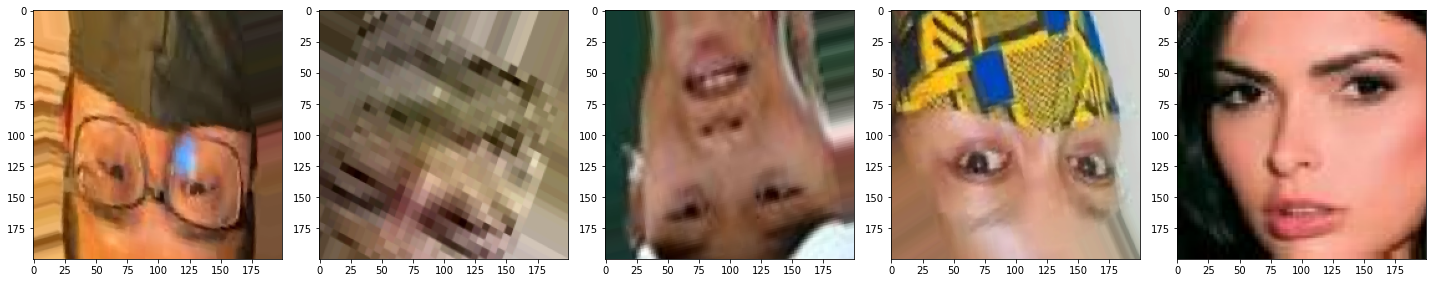

In [94]:
plot_image(sample_training_img[0:5])

## Creating and Training the Model

In [95]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (IMG_SHAPE,IMG_SHAPE, 3)),
    tf.keras.layers.MaxPool2D(4,4),

    tf.keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(4,4),

    tf.keras.layers.Conv2D(128,(3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(4,4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')

])

In [96]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 3, 3, 128)       

In [97]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [98]:
class earlyStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs is not None and logs.get('accuracy') > 0.99:
            print("\nAccuracy attained! Stopping training now")
            self.model.stop_training = True

In [99]:
EPOCHS = 50

history = model.fit(
        train_data_gen,
        steps_per_epoch = int(train_examples/BATCH_SIZE),
        epochs = EPOCHS,
        validation_data = validation_data_gen,
        validation_steps = int(val_examples/BATCH_SIZE)
    )

Epoch 1/50
40/40 [==============================] - 50s 1s/step - loss: 0.3884 - accuracy: 0.8168 - val_loss: 0.2101 - val_accuracy: 0.9173
Epoch 2/50
40/40 [==============================] - 49s 1s/step - loss: 0.2280 - accuracy: 0.9083 - val_loss: 0.1685 - val_accuracy: 0.9280
Epoch 3/50
40/40 [==============================] - 48s 1s/step - loss: 0.1785 - accuracy: 0.9323 - val_loss: 0.1593 - val_accuracy: 0.9360
Epoch 4/50
40/40 [==============================] - 48s 1s/step - loss: 0.1433 - accuracy: 0.9465 - val_loss: 0.0923 - val_accuracy: 0.9707
Epoch 5/50
40/40 [==============================] - 49s 1s/step - loss: 0.1343 - accuracy: 0.9529 - val_loss: 0.0870 - val_accuracy: 0.9720
Epoch 6/50
40/40 [==============================] - 49s 1s/step - loss: 0.1073 - accuracy: 0.9596 - val_loss: 0.0452 - val_accuracy: 0.9867
Epoch 7/50
40/40 [==============================] - 49s 1s/step - loss: 0.0994 - accuracy: 0.9656 - val_loss: 0.0359 - val_accuracy: 0.9880
Epoch 8/50
40/40 [==

## Progress of the Training (Loss and Accuracy over the epochs)

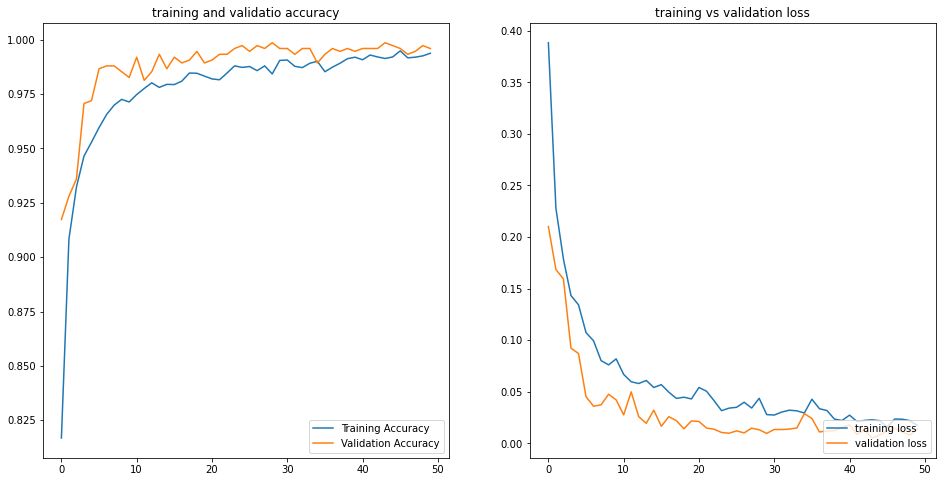

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize = (16, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('training and validation accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = "training loss")
plt.plot(epochs_range, val_loss, label = "validation loss")
plt.legend(loc = 'lower right')
plt.title('training vs validation loss')

plt.show()

In [103]:
model.evaluate(test_data_gen)

4/4 [==============================] - 2s 610ms/step - loss: 0.0242 - accuracy: 0.9960


[0.024204732850193977, 0.9959677457809448]

## Saving the model

In [102]:
model.save('saved_model/CNN3')
model.save('Best_Models/CNN3.h5')

INFO:tensorflow:Assets written to: saved_model1/CNN2\assets
